### Cargar un modelo Word2Vec pre-entrenado para el español

ver: https://github.com/dccuchile/spanish-word-embeddings

In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_Twitter_def_v1.csv"
df = pd.read_csv(dataset)



In [3]:
df

,Unnamed: 0,tipoT,Date,TwitterAccountName,Message,Link,TweetType,ReTweets,Likes,Quote,Reply,TotalInteractions,TwitterAccount,TweetContentURL,Followers,X,X.1
0,1,2,"Dec 31, 2021 @ 17:20:01.000",thecliniccl,📲 15 tuits políticos que envejecieron mal: jug...,https://twitter.com/twitter/statuses/147701168...,Tweet,1,4,0,0,5,The Clinic,http://ow.ly/XKPY30s5LnU,"2,084,724",NaN,NaN
1,2,2,"Dec 31, 2021 @ 14:03:51.000",PublimetroChile,En “Contigo en la Mañana” se dio un extraña co...,https://twitter.com/twitter/statuses/147696231...,Tweet,0,4,0,1,5,Publimetro,https://www.publimetro.cl/entretenimiento/2021...,"1,256,665",NaN,NaN
2,3,2,"Dec 31, 2021 @ 13:32:54.000",thecliniccl,"🤦🏻‍♂️ ¿Otra más? Servel desmintió ""fake news"" ...",https://twitter.com/twitter/statuses/147695452...,Tweet,7,17,1,3,28,The Clinic,https://www.theclinic.cl/2021/12/30/fake-news-...,"2,084,724",NaN,NaN
3,4,2,"Dec 31, 2021 @ 13:04:41.000",El_Ciudadano,Otra fake news: Servel desmiente fraude electo...,https://twitter.com/twitter/statuses/147694742...,Tweet,10,19,3,3,35,El Ciudadano,https://bit.ly/3EJK8t1,"540,685",NaN,NaN
4,5,2,"Dec 31, 2021 @ 11:40:02.000",lacuarta,Antivacunas irrumpió en despacho de Contigo en...,https://twitter.com/twitter/statuses/147692612...,Tweet,5,13,1,14,33,La Cuarta,http://la4.cl/t4r881,"895,93",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,5360,2,"Jan 11, 2017 @ 01:20:00.000",Emol,"Trump asegura que información ""comprometedora""...",https://twitter.com/twitter/statuses/819036112...,Tweet,1,3,0,0,4,Emol.com,http://bit.ly/2iZsXeN,"2,092,265",NaN,NaN
5360,5361,2,"Jan 11, 2017 @ 00:20:01.000",Emol,"Trump asegura que información ""comprometedora""...",https://twitter.com/twitter/statuses/819021014...,Tweet,3,1,1,2,7,Emol.com,http://bit.ly/2iZsXeN,"2,092,265",NaN,NaN
5361,5362,2,"Jan 10, 2017 @ 23:20:01.000",Emol,"Trump asegura que información ""comprometedora""...",https://twitter.com/twitter/statuses/819005915...,Tweet,6,2,1,1,10,Emol.com,http://bit.ly/2iZsXeN,"2,092,265",NaN,NaN
5362,5363,2,"Jan 10, 2017 @ 22:46:02.000",Emol,"Trump asegura que información ""comprometedora""...",https://twitter.com/twitter/statuses/818997366...,Tweet,4,0,2,2,8,Emol.com,http://bit.ly/2iZsXeN,"2,092,265",NaN,NaN


In [4]:
noticias = df.Message

In [5]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


In [6]:
import re
# Remove Emails
noticias = [re.sub(r'\S*@\S*\s?', '', sent) for sent in noticias]

# Remove new line characters
noticias = [re.sub(r'\s+', ' ', sent) for sent in noticias]

# Remove distracting single quotes
noticias= [re.sub("\'", "", sent) for sent in noticias]

# Remove links
noticias = [re.sub(r'\S*http\S*\s?', '', sent) for sent in noticias]
noticias = [re.sub(r'\S*https\S*\s?', '', sent) for sent in noticias]


In [7]:
documents=[]
for noticia in noticias:
    documents.append(spacy_tokenizer(noticia))

In [8]:
etm_documents=[]
for document in documents:
    etm_documents.append(" ".join(document))

In [9]:
from embedded_topic_model.utils import preprocessing
import json

# Preprocessing the dataset
diccionario, train_dataset,test_dataset, = preprocessing.create_etm_datasets(
    etm_documents, 
    min_df=0.01, 
    max_df=0.75, 
    train_size=0.85, 
)



In [ ]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance
perp =[]
numk = range(1,12)
for k in numk:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=k,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))



/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

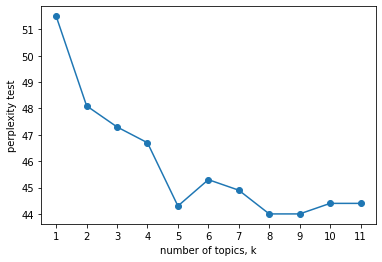

In [11]:
import matplotlib.pyplot as plt
plt.plot(numk, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [12]:
from embedded_topic_model.models.etm import ETM
etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=4,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

etm_instance.fit(train_dataset, test_dataset)

In [13]:
import numpy as np
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=4
nDoc = len(dist)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)
print(topics)

[['desinformación', 'red', 'social', 'campaña', 'falso', 'gobierno', 'chile', 'noticia', 'acusar', 'circular', 'él', 'rt', 'facebook', 'piñera', 'año', 'coronavirus', 'plebiscito', 'crisis', 'político', 'pandemia'], ['fake', 'new', 'desmentir', 'news', 'rt', 'kast', 'boric', 'real', 'the', 'historia', 'vivo', 'hecho', 'falso', 'mentira', 'antonio', 'comentar', 'capítulo', 'basado', 'podcast', 'sacerdote'], ['falso', 'noticia', 'información', 'difundir', 'facebook', 'rt', 'whatsapp', 'entregar', 'incendio', 'pedir', 'difusión', 'bolsonaro', 'fiscalía', 'persona', 'twitter', 'video', 'denuncia', 'corte', 'caso', 'vacuna'], ['noticia', 'falso', 'fake', 'new', 'trump', 'elección', 'podcast', 'carrera', 'vallejo', 'camila', 'gonzalo', 'igtv', 'presidencial', 'electoral', 'lamesa13', 'conversar', 'unidos', 'malo', 'capítulo', 'valdivia']]


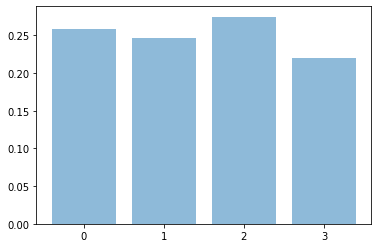

[0.12895715, 0.07827654, 0.07706, 0.0519935, 0.034456067, 0.02946689, 0.026772717, 0.026112093, 0.023726067, 0.023640431, 0.022807444, 0.019550825, 0.01798488, 0.017842835, 0.017693492]


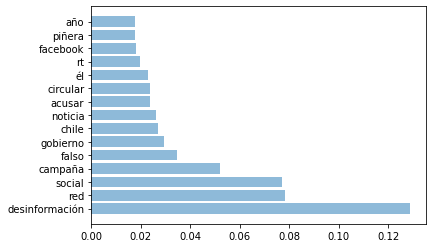

[0.26525345, 0.24168237, 0.022818884, 0.019123634, 0.018035753, 0.017961035, 0.017888198, 0.015405877, 0.014689017, 0.014270558, 0.01364168, 0.013537572, 0.013131279, 0.012659651, 0.012007025]


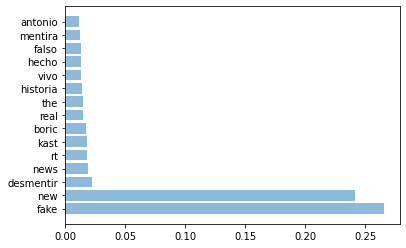

[0.24092953, 0.13130316, 0.12199983, 0.03203879, 0.022366274, 0.021415437, 0.02111927, 0.01969755, 0.017201109, 0.013865885, 0.013470849, 0.012631408, 0.012556374, 0.01218546, 0.011723756]


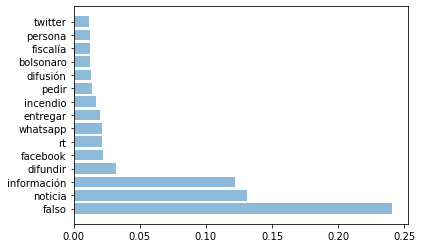

[0.13033043, 0.1164433, 0.05592736, 0.050582904, 0.029158663, 0.028747153, 0.023691865, 0.023610845, 0.02332984, 0.023105342, 0.022169065, 0.020255411, 0.019460741, 0.01781055, 0.017131664]


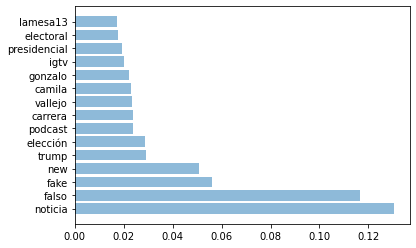

In [14]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
#plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
#show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



In [15]:
doc_l = np.zeros(len(train_dataset['counts']))
term_f= np.zeros(len(diccionario))
for i in range(0,len(train_dataset['counts'])):
        for j in range(0,len(train_dataset['counts'][i])):
                js = train_dataset['tokens'][i][j]
             
                term_f[js] = term_f[js] + train_dataset['counts'][i][j]
                doc_l[i] = doc_l[i]+ train_dataset['counts'][i][j]

In [16]:
import pyLDAvis
prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

In [17]:
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)
print(etm_instance._perplexity(test_dataset))


-0.04331977335727186
0.88
46.4
